## Lateral displacements

In this notebook we explore a few different things. 
- We can compute mixing length scales as variance divided by gradient. This is a nice metric when we are thinking about how a gradient gets mixed.
- We can also potentially compute a subduction length scale as the nearest mean upwelling region that had similar properties. Maybe this can be done using spice. 

Combining these length scales, with a time scale can help. 
Timescale can also be computed in multiple ways:
- Either using some estimate of EKE along with a length scale
- Or getting a ventilation timescale using the AOU. 

In [30]:
import numpy as np
import xarray as xr
import gsw
import matplotlib.pyplot as plt

In [2]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data/data/'

In [3]:
# Climatology data
Tclim = xr.open_dataset(data_dir + "raw/climatology/RG_ArgoClim_Temperature_2017.nc", decode_times=False)
Sclim = xr.open_dataset(data_dir + "raw/climatology/RG_ArgoClim_Salinity_2017.nc", decode_times=False)

In [6]:
Climextra = xr.open_mfdataset(data_dir+ 'raw/climatology/RG_ArgoClim_201*', decode_times=False)

In [18]:
RG_clim = xr.merge([Tclim, Sclim, Climextra])

In [19]:
# Calendar type was missing, and giving errors in decoding time
RG_clim.TIME.attrs['calendar'] = '360_day'
RG_clim = xr.decode_cf(RG_clim);

In [20]:
## Add density and other things 
SA = xr.apply_ufunc(gsw.SA_from_SP, RG_clim.ARGO_SALINITY_MEAN+RG_clim.ARGO_SALINITY_ANOMALY, RG_clim.PRESSURE , 
                                    RG_clim.LONGITUDE, RG_clim.LATITUDE,
                    dask='parallelized', output_dtypes=[float,]).rename('SA')
CT = xr.apply_ufunc(gsw.CT_from_t, SA, RG_clim.ARGO_TEMPERATURE_MEAN+RG_clim.ARGO_TEMPERATURE_ANOMALY, RG_clim.PRESSURE, 
                     dask='parallelized', output_dtypes=[float,]).rename('CT')
SIGMA0 = xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float,]).rename('SIGMA0')

In [22]:
RG_clim = xr.merge([RG_clim, SA, CT, SIGMA0])

In [23]:
CT_region = RG_clim.CT.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-65,-30), PRESSURE=slice(0,1200)
    ).groupby('TIME.month').mean().load()
SA_region = RG_clim.SA.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-65,-30), PRESSURE=slice(0,1200)
    ).groupby('TIME.month').mean().load()
rho_region = RG_clim.SIGMA0.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-65,-30), PRESSURE=slice(0,1200)
    ).groupby('TIME.month').mean().load()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [24]:
Clim_region = xr.merge([CT_region, SA_region, rho_region])

In [25]:
Clim_region

<xarray.Dataset>
Dimensions:    (LATITUDE: 35, PRESSURE: 48, month: 12)
Coordinates:
    LONGITUDE  float32 30.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... -32.5 -31.5 -30.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 ... 1.1e+03 1.15e+03 1.2e+03
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    CT         (PRESSURE, LATITUDE, month) float64 0.1809 0.947 ... nan nan
    SA         (PRESSURE, LATITUDE, month) float64 33.87 33.97 34.02 ... nan nan
    SIGMA0     (PRESSURE, LATITUDE, month) float64 27.05 27.1 27.17 ... nan nan

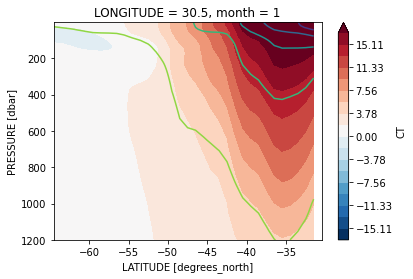

In [33]:
Clim_region.CT.isel(month=0).plot.contourf(levels=19, vmin=-17)
Clim_region.SIGMA0.isel(month=0).plot.contour()
plt.gca().invert_yaxis()